In [1]:
%matplotlib notebook
import logging
import os
import math
import multiprocessing
import json
import re

from scipy.stats import t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import natsort

plt.rc("font", size=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=14)
plt.rc("figure", titlesize=14)

In [83]:
use_markers = False
experiment_type = "cv2x"

use_line_types = False
image_format = "png"
figure_store = "../data/figures/"

overall_now="12:00:00"
confidence_intervals = False

## Runner for overall job

In [84]:
def generate_graphs(result_folders, now):

    print("Beginning graphing of result file: {}".format(result_folders))

    if not config["processed-result-dir"]:
        config["processed-result-dir"] = prepare_results(result_folders, now)

    for graph_title in results_["graph-configurations"]:
        print("Graphing configuration: {}".format(graph_title))
        folders_for_comparison = []
        configurations = []
        for configuration in results_["graph-configurations"][graph_title]:
            for folder in config["processed-result-dir"]:
                config_name = folder.split("/")[-1][:-20]
                if configuration == config_name:
                    folders_for_comparison.append(folder)
                    configurations.append(configuration)

        for graph in results_["graphs"]:
            if graph in ["PDR-SCI", "PDR-TB", "IPG"]:
                distance_graph(folders_for_comparison, graph, graph_title, configurations, now)
            elif graph == "CBR":
                cbr_graph(folders_for_comparison, graph, graph_title, configurations, now)

## Results Preparation stage

In [85]:
def prepare_results(result_folders, now):

    num_processes = config["parallel_processes"]
    if num_processes > multiprocessing.cpu_count():
        print("Too many processes, going to revert to total - 1")
        num_processes = multiprocessing.cpu_count() - 1

    processed_results = []
    for folder in result_folders:
        config_name = folder.split("/")[-1][:-20]
        print("Results for config: {}".format(config_name))
        folder_results = []
        files = natsort.natsorted(os.listdir(folder))

        filtered_files = []
        for i in range(len(files)):
            # Ensures we don't load files passed by accident
            if ".csv" in files[i]:
                filtered_files.append("{}/{}".format(folder, files[i]))

        i = 0
        while i < len(filtered_files):
            if len(filtered_files) < num_processes:
                num_processes = len(filtered_files)
            pool = multiprocessing.Pool(processes=num_processes)

            folder_results.append(pool.starmap(generate_results, zip(filtered_files[i: i + num_processes])))

            pool.close()
            pool.join()

            i += num_processes

        folder_results = [y for x in folder_results for y in x]
        # Go through each of the available stats and write them out to a csv file.
        output_csv_dir = "/Users/brianmccarthy/git_repos/results-analysis/data/processed_data/{}/{}-{}".format(
            os.getcwd(), experiment_type,config_name, now)
        
        return folder_results

        os.makedirs(output_csv_dir, exist_ok=True)

        # Shortcut ensures we get the stats from the parsed results
        for stat in folder_results[0]:
            if stat == "CBR":
                across_run_results_cbr(folder_results, output_csv_dir)
            else:
                across_run_results(folder_results, stat, output_csv_dir, "Distance")

        processed_results.append(output_csv_dir)

    print("Folders processed: {}".format(processed_results))
    return processed_results

In [164]:
def generate_results(output_csv):

    print("Generating results for file: {}".format(output_csv))

    results = {}

    pdr_sci_agg = pd.DataFrame()
    pdr_tb_agg = pd.DataFrame()
    # pdr_tb_ignore_sci_agg = pd.DataFrame()
    ipg_agg = pd.DataFrame()
    cbr_agg = pd.DataFrame()
    unsensed_errors = pd.DataFrame()
    hd_errors = pd.DataFrame()
    prop_errors = pd.DataFrame()
    interference_errors = pd.DataFrame()

    error_dfs = {}
    # Need a new for loop through all the errors and adding them as a stat distance
    for error in results_["errors"]:
        error_dfs[error] = pd.DataFrame()
    
    for chunk in pd.read_csv(output_csv, chunksize=10 ** 6):
        
        # CBR calculation doesn't aggregate the same way as the above so dealt with separately
        cbr_df = chunk[["Time", "cbr"]]
        cbr_df = cbr_df[cbr_df["cbr"] > -1]

        if cbr_agg.empty:
            cbr_agg = cbr_df
        else:
            cbr_agg = cbr_agg.append(cbr_df)
            

        # SCI PDR calculation
        pdr_sci_agg = stat_distance(pdr_sci_agg, chunk, "sciDecoded", "txRxDistanceSCI", True)

        # TB PDR calculation
        pdr_tb_agg = stat_distance(pdr_tb_agg, chunk, "tbDecoded", "txRxDistanceTB", True)

        # pdr_tb_ignore_sci_agg = self.stat_distance(pdr_tb_agg, chunk, "tbDecodedIgnoreSCI", "txRxDistanceTB", True)

        # IPG calculation
        ipg_agg = stat_distance(ipg_agg, chunk, "interPacketDelay", "txRxDistanceTB", False)

        chunk = chunk[chunk["tbReceived"] != -1]
        for error in error_dfs:
            if "sci" in error[0:3]:
                error_dfs[error] = stat_distance(error_dfs[error], chunk, error, "txRxDistanceSCI", True)
            else:
                error_dfs[error] = stat_distance(error_dfs[error], chunk, error, "txRxDistanceTB", True)

    results["PDR-SCI"] = pdr_sci_agg
    results["PDR-TB"] = pdr_tb_agg
    # results["PDR-IGNORE-SCI"] = pdr_tb_ignore_sci_agg
    results["IPG"] = ipg_agg
    results["CBR"] = cbr_agg

    for key, df in zip(["unsensed_errors", "hd_errors", "prop_errors", "interference_errors"],
                       [unsensed_errors, hd_errors, prop_errors, interference_errors]):
        for error in results_[key]:
            if df.empty:
                df = error_dfs[error]
            else:
                # Combine mean errors
                df["mean"] = df["mean"] + error_dfs[error]["mean"]

        results[key] = df

    return results

In [151]:
def stat_distance(agg_df, df, stat, distance, percentage):

    # Reduce the size of the DF to what we're interested in.
    distance_df = df[df[stat].notnull()]
    distance_df = distance_df[(distance_df["posX"] > 0) & (distance_df["posX"] < 2000)]
    distance_df = distance_df[["Time", "NodeID", stat, distance]]
    distance_df = distance_df[distance_df[stat] > -1]
    distance_df = distance_df.rename(columns={"Time": "Time", "NodeID": "NodeID", stat: stat, distance: "Distance"})

    # Only interested in max 500m simply as it's not all that relevant to go further.
    # Note that going to the max distance of the file can cause issues with how they are parsed.
    max_distance = min(530, distance_df["Distance"].max())

    # Get the mean, std, count for each distance
    distance_df = distance_df.groupby(
        pd.cut(distance_df["Distance"], np.arange(0, max_distance, 10))).agg(
        {stat: [np.mean, "count"]})

    # Remove over head column
    distance_df.columns = distance_df.columns.droplevel()

    if percentage:
        distance_df = distance_df.apply(lambda x: x * 100, axis=1)

    if agg_df.empty:
        agg_df = distance_df
    else:
        # combine_chunks
        agg_df = pd.merge(agg_df, distance_df, on="Distance", how='outer')
        agg_df = agg_df.apply(combine_line, axis=1, result_type='expand')
        agg_df = agg_df.rename({0: "mean", 1: "count"}, axis='columns')

    return agg_df

In [152]:
def combine_line(line):
    mean_a = line["mean_x"]
    count_a = line["count_x"]

    mean_b = line["mean_y"]
    count_b = line["count_y"]

    if np.isnan(mean_a) and np.isnan(mean_b):
        return [mean_a, count_a]
    elif np.isnan(mean_a) and not np.isnan(mean_b):
        return [mean_b, count_b]
    elif np.isnan(mean_b) and not np.isnan(mean_a):
        return [mean_a, count_a]
    else:
        ex_a = mean_a * count_a
        ex_b = mean_b * count_b

        tx = ex_a + ex_b
        tn = count_a + count_b

        overall_mean = tx / tn
        overall_count = tn

        return [overall_mean, overall_count]

In [153]:
def across_run_results(results, stat, output_csv_dir, merge_col):
    
    df = pd.DataFrame()
    print("Statistic of interest: {}".format(stat))
    for i in range(len(results)):
        if df.empty:
            df = results[i][stat]
        else:
            df = pd.merge(df, results[i][stat], how='outer', on=merge_col,
                          suffixes=(i, i + 1),
                          copy=True, indicator=False)

    mean_cols = df.filter(regex='mean').columns

    n = len(mean_cols) - 1
    t_value = t.ppf(p, n)

    df = df.apply(combine_runs, axis=1, result_type='expand', args=(mean_cols, t_value,))
    df = df.rename({0: "Mean", 1: "Confidence-Interval"}, axis='columns')
    df.to_csv("{}/{}.csv".format(output_csv_dir, stat))


In [154]:
def across_run_results_cbr(results, output_csv_dir):
    earliest_time = float("inf")
    latest_time = -float("inf")

    raw_cbr_df = pd.DataFrame()
    for folder in results:

        start_time = folder["CBR"]["Time"].min()
        if start_time < earliest_time:
            earliest_time = start_time

        end_time = folder["CBR"]["Time"].max()
        if end_time > latest_time:
            latest_time = end_time

        if raw_cbr_df.empty:
            raw_cbr_df = folder["CBR"]
        else:
            raw_cbr_df.append(folder["CBR"])

    print("Earliest time: {}s Latest time: {}s".format(earliest_time, latest_time))

    cbr_df = pd.DataFrame(columns=["Mean", "Time", "Confidence-Interval"])
    last_time = earliest_time
    for i in np.arange(earliest_time, latest_time, 0.1):
        subsection_df = pd.DataFrame()
        for folder in results:
            df = folder["CBR"]
            if subsection_df.empty:
                subsection_df = df[(df["Time"] < i) & (df["Time"] >= last_time) & (df["cbr"].notnull())]
            else:
                subsection_df.append(df[(df["Time"] < i) & (df["Time"] >= last_time) & (df["cbr"].notnull())])

        last_time = i

        cbr_df = cbr_df.append({"Mean": subsection_df["cbr"].mean(),
                                "Time": (i + last_time) / 2,
                                "Confidence-Interval": subsection_df["cbr"].std()
                                }, ignore_index=True)

    cbr_df.to_csv("{}/CBR.csv".format(output_csv_dir), index=False)
    raw_cbr_df.to_csv("{}/raw-CBR.csv".format(output_csv_dir), index=False)

In [155]:
def combine_runs(line, mean_cols, t_value):
    means = []
    for mean in mean_cols:
        means.append(line[mean])

    n = len(means)

    # Average Across runs
    xBar = sum(means) / n

    # Deviation between runs and average
    deviation = []
    for mean in means:
        deviation.append((mean - xBar) ** 2)
    s2 = sum(deviation) / (n - 1)

    # Confidence interval
    ci = t_value * math.sqrt(s2 / n)

    return [xBar, ci]

### Graphing stage

In [156]:
def distance_graph(folders, graph_type, graph_title, graph_info, now):
    means = []
    cis = []
    distances = []
    for folder in folders:
        df = pd.read_csv("{}/{}.csv".format(folder, graph_type))
        means.append(list(df["Mean"]))
        if confidence_intervals:
            cis.append(list(df["Confidence-Interval"]))
        distances = (list(range(0, df.shape[0] * 10, 10)))
        
    graph_info["means"] = means
    graph_info["cis"] = cis

    if graph_type in ["PDR-SCI", "PDR-TB"]:
        dist_graph(distances, graph_info, "{}-{}".format(graph_title, graph_type),
                   ylabel="Packet Delivery Rate %", now=now, confidence_intervals=cis, show=False, store=True)

In [157]:
def cbr_graph(folders, graph_type, graph_title, graph_info, now):
    # Might change this to time based graph but CBR is fine for now
    times = []
    cbrs = []
    cis = []
    for folder in folders:
        cbr = []
        time = []
        ci = []
        df = pd.read_csv("{}/CBR.csv".format(folder))
        times.append(list(df["Time"]))
        cbrs.append(list(df["cbr"]))
        if confidence_intervals:
            cis.append(list(df["Confidence-Interval"]))
        

    graph_info["means"] = cbrs
    graph_info["times"] = times
    graph_info["cis"] = cis

    cbr_plot(graph_info, "{}-{}".format(graph_title, graph_type), now=now,
             confidence_intervals=confidence_intervals, show=True, store=False)

In [158]:
def dist_graph(distances, graph_info, plot_name, ylabel, now, legend_pos="lower left",
               confidence_intervals=None, show=True, store=False):
    fig, ax = plt.subplots()

    for i in range(len(graph_info["config_name"])):
        if confidence_intervals:
            ax.errorbar(distances, means[i], yerr=confidence_intervals[i], label=labels[i])
        else:
            ax.plot(distances, graph_info["means"][i], label=graph_info["labels"][i],
                    fillstyle="none", marker=graph_info["markers"][i], markevery=5,
                    color=graph_info["colors"][i], linestyle=graph_info["linestyles"][i])

    ax.set(xlabel='Distance (m)', ylabel=ylabel)
    ax.legend(loc=legend_pos)
    ax.tick_params(direction='in')
    
    ax.set_xlim([0, 500])
    ax.set_ylim([0, 100])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))
    plt.yticks(np.arange(0, 101, step=10))
    plt.grid(b=True, alpha=0.5)

    if show:
        fig.show()
        
    print("{}/{}-{}".format(figure_store, plot_name, now))

    if store:
        fig.savefig("{}/{}-{}.png".format(figure_store, plot_name, now), dpi=300)
    plt.close(fig)

In [159]:
def cbr_plot(graph_info, plot_name, now, confidence_intervals=None, show=True, store=False):

    fig, ax = plt.subplots()

    for i in range(len(graph_info["config_name"])):
        if confidence_intervals:
            ax.errorbar(graph_info["times"][i], graph_info["means"][i], yerr=confidence_intervals[i],
                        label=graph_info["labels"][i],
                        fillstyle="none", color=graph_info["colors"][i], linestyle=graph_info["linestyles"][i])
        else:
            ax.plot(graph_info["times"][i], graph_info["means"][i], label=graph_info["labels"][i],
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color=graph_info["colors"][i], linestyle=graph_info["linestyles"][i])

    ax.legend(loc='upper left')
    ax.set(xlabel='Time (s)', ylabel='Channel Busy Ratio %')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))
    plt.grid(b=True, alpha=0.5)

    if show:
        fig.show()

    if store:
        fig.savefig("{}/{}-{}.png".format(figure_store, plot_name, now), dpi=400)

In [160]:
def errors_dist(distances, decoded, decoded_labels, errors, error_labels, plot_name):
    # TODO: Update to allow such graphing to be automatically configured.

    fig, ax = plt.subplots()

    if use_markers:
        for i in range(len(decoded)):
            ax.plot(distances, decoded[i], label=decoded_labels[i], marker=markers[i], markevery=3)

            for j in range(len(errors[i])):
                ax.plot(distances, errors[i][j], label=error_labels[i][j], marker=markers[i + j])

    elif use_line_types:
        for i in range(len(decoded)):
            ax.plot(distances, decoded[i], label=decoded_labels[i])

            for j in range(len(errors[i])):
                ax.plot(distances, errors[i][j], label=error_labels[i][j])

    else:
        for i in range(len(decoded)):
            ax.plot(distances, decoded[i], label=decoded_labels[i])

            for j in range(len(errors[i])):
                ax.plot(distances, errors[i][j], label=error_labels[i][j])

    ax.legend(loc='center left')

    ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate (PDR) %')
    ax.grid()

    ax.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, step=.1))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    fig.savefig("{}/{}-{}.png".format(figure_store, plot_name, now), dpi=300)
    plt.close(fig)

In [161]:
config_file = "/Users/brianmccarthy/git_repos/results-analysis/configs/cv2x.json"
with open(config_file) as config_json:
    config = json.load(config_json)[experiment_type]
results_ = config["results"]
p = results_["confidence-interval"]
now="00_00_00"

In [162]:
folder_results = prepare_results(["/Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/Fast-2020-05-28-23_03_07"], now)

Results for config: Fast
Generating results for file: /Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/Fast-2020-05-28-23_03_07/run-2.csv
Generating results for file: /Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/Fast-2020-05-28-23_03_07/run-1.csv
Generating results for file: /Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/Fast-2020-05-28-23_03_07/run-4.csv
Generating results for file: /Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/Fast-2020-05-28-23_03_07/run-3.csv
Generating results for file: /Users/brianmccarthy/git_repos/results-analysis/data/parsed_data/cv2x/Fast-2020-05-28-23_03_07/run-5.csv
Min Time: 500.004s Max Time: 507.588s in this chunk
Min Time: 500.005s Max Time: 507.628s in this chunk
Min Time: 500.004s Max Time: 507.557s in this chunk
Min Time: 500.006s Max Time: 507.585s in this chunk
Min Time: 500.001s Max Time: 507.524s in this chunk
Min Time: 507.59s Max Time: 511.999s in this 

In [163]:
print(folder_results[0]["CBR"].min())
print(folder_results[0]["CBR"].max())

Time    500.006
cbr       0.000
dtype: float64
Time    507.585000
cbr       0.537415
dtype: float64


In [ ]:
nonPeriodic-3GPP-012vpm-1ms-2021-01-14-15_58_28
nonPeriodic-ETSI-012vpm-1ms-2021-01-14-15_57_12

In [2]:
df_3gpp = pd.read_csv("/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-3GPP-012vpm-2021-01-24-12_12_32/run-1.csv")

In [3]:
df_etsi = pd.read_csv("/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-012vpm-2021-01-24-11_27_16/run-1.csv")

In [4]:
message_arrivals_3gpp = df_3gpp[["NodeID", "Time", "messageArrival"]]

message_arrivals_3gpp = message_arrivals_3gpp[message_arrivals_3gpp['messageArrival'].notna()]

message_arrivals = message_arrivals_3gpp.sort_values(by=["NodeID", "Time"])

differences = message_arrivals.diff()["Time"].to_list()

positive_diff_3gpp = []
for diff in differences:
    if diff > 0:
        positive_diff_3gpp.append(diff * 1000)
        
        
message_arrivals_etsi = df_etsi[["NodeID", "Time", "messageArrival"]]

message_arrivals_etsi = message_arrivals_etsi[message_arrivals_etsi['messageArrival'].notna()]

message_arrivals_etsi = message_arrivals_etsi.sort_values(by=["NodeID", "Time"])

differences = message_arrivals_etsi.diff()["Time"].to_list()

positive_diff_etsi = []
for diff in differences:
    if diff > 0.1:
        positive_diff_etsi.append(diff * 1000)

In [2]:
configs = {
    "3GPP-006vpm": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-3GPP-006vpm-2021-02-19-10_12_41",
    "3GPP-012vpm": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-3GPP-012vpm-2021-02-18-17_25_27",
    "3GPP-02vpm" : "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-3GPP-02vpm-2021-02-19-10_32_49",
    "3GPP-03vpm" : "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-3GPP-03vpm-2021-02-20-17_25_24",
    "ETSI-006vpm": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-006vpm-2021-02-19-10_12_41",
    "ETSI-012vpm": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-012vpm-2021-02-18-17_26_27",
    "ETSI-02vpm" : "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-02vpm-2021-02-19-10_22_59",
    "ETSI-03vpm" : "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-03vpm-2021-02-19-12_11_24"
}

In [3]:
df = pd.read_csv("{}/run-1.csv".format(configs["3GPP-006vpm"]))

df = df[["NodeID", "Time", "messageArrival"]]

message_arrivals.append(df[df['messageArrival'].notna()])
            
message_arrivals = message_arrivals.sort_values(by=["NodeID", "Time"])

differences = message_arrivals.diff()["Time"].to_list()

for diff in differences:
    if diff > 0.1:
        positive_diff.append(diff * 1000)
        
print("Time:{}ms".format(sum(positive_diff)/len(positive_diff)))

NameError: name 'message_arrivals' is not defined

In [ ]:
df = pd.read_csv("{}/run-1.csv".format(configs["3GPP-006vpm"]))

df = df[["NodeID", "Time", "messageArrival"]]

message_arrivals.append(df[df['messageArrival'].notna()])
            
message_arrivals = message_arrivals.sort_values(by=["NodeID", "Time"])

message_arrivals["Differences"] = message_arrivals.diff()["Time"].to_list()

message_arrivals = message_arrivals[message_arrivals["Differences"] > 0]

In [4]:
messageArrivalRates = {}
for config in configs:
    print("="*40)
    print(config)
    positive_diff = []
    for run_num in range(1,6):
        chunk_num = 1
        message_arrivals = pd.DataFrame()
        for chunk in pd.read_csv("{}/run-{}.csv".format(configs[config], run_num), chunksize=10 ** 6):

            chunk = chunk[["NodeID", "Time", "messageArrival"]]
            
            if message_arrivals.empty:
                message_arrivals = chunk[chunk['messageArrival'].notna()]
            else:
                message_arrivals.append(chunk[chunk['messageArrival'].notna()])
            
            chunk_num += 1

        message_arrivals = message_arrivals.sort_values(by=["NodeID", "Time"])

        differences = message_arrivals.diff()["Time"].to_list()

        for diff in differences:
            if "3GPP" in config:
                if diff > 0.05:
                    positive_diff.append(diff * 1000)
            elif "ETSI" in config:
                if diff > 0.1:
                    positive_diff.append(diff * 1000)
    messageArrivalRates[config] = positive_diff
    
    print("Time:{}ms".format(sum(positive_diff)/len(positive_diff)))

3GPP-006vpm
Time:100.27636767564562ms
3GPP-012vpm
Time:99.40765567119423ms
3GPP-02vpm
Time:97.61860534791398ms
3GPP-03vpm
Time:92.88210341868646ms
ETSI-006vpm
Time:122.3704679376086ms
ETSI-012vpm
Time:250.22633931954252ms
ETSI-02vpm
Time:384.11935621706306ms
ETSI-03vpm
Time:610.1765420844722ms


In [11]:
len(messageArrivalRates["ETSI-03vpm"])
over_100 = []
over_200 = []
over_300 = []
over_400 = []
over_500 = []
count_under_200 = 0
for rate in messageArrivalRates["ETSI-03vpm"]:
    if rate < 200:
        count_under_200 += 1
    else:
        over_200.append(rate)

In [12]:
for key in messageArrivalRates:
    print(key)
    print(max(messageArrivalRates[key]))

3GPP-006vpm
630.9999999999718
3GPP-012vpm
564.9999999999977
3GPP-02vpm
454.99999999992724
3GPP-03vpm
388.0000000000905
ETSI-006vpm
134.0000000000714
ETSI-012vpm
285.0000000001387
ETSI-02vpm
479.00000000004184
ETSI-03vpm
733.9999999999804


In [14]:
count_under_200

18

In [78]:
print(sum(over_200)/len(over_200))

ZeroDivisionError: division by zero

<IPython.core.display.Javascript object>


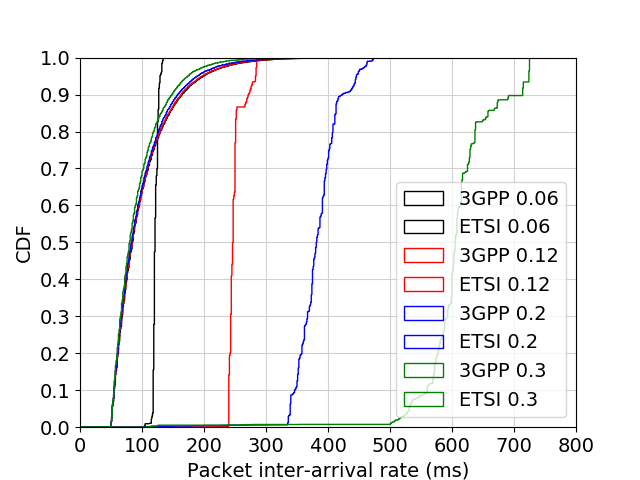

In [15]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1000, 1) 
n, bins, patches = ax.hist(messageArrivalRates["3GPP-006vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='3GPP 0.06', color="black")

# Overlay a reversed cumulative histogram.
ax.hist(messageArrivalRates["ETSI-006vpm"], bins=bins, density=True, histtype='step', cumulative=True,
        label='ETSI 0.06', color="black")

ax.hist(messageArrivalRates["3GPP-012vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='3GPP 0.12', color="red")

# Overlay a reversed cumulative histogram.
ax.hist(messageArrivalRates["ETSI-012vpm"], bins=bins, density=True, histtype='step', cumulative=True,
        label='ETSI 0.12', color="red")

ax.hist(messageArrivalRates["3GPP-02vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='3GPP 0.2', color="blue")

# Overlay a reversed cumulative histogram.
ax.hist(messageArrivalRates["ETSI-02vpm"], bins=bins, density=True, histtype='step', cumulative=True,
        label='ETSI 0.2', color="blue")

ax.hist(messageArrivalRates["3GPP-03vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='3GPP 0.3', color="green")

ax.hist(messageArrivalRates["ETSI-03vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='ETSI 0.3', color="green")


# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Packet inter-arrival rate (ms)')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,400])
ax.set_xticks(np.arange(0,801, 100))
ax.set_yticks(np.arange(0,1.01, 0.1))

plt.show()
# plt.savefig("3GPP-ETSI-packet-interarrival.eps")
# plt.close()


<IPython.core.display.Javascript object>


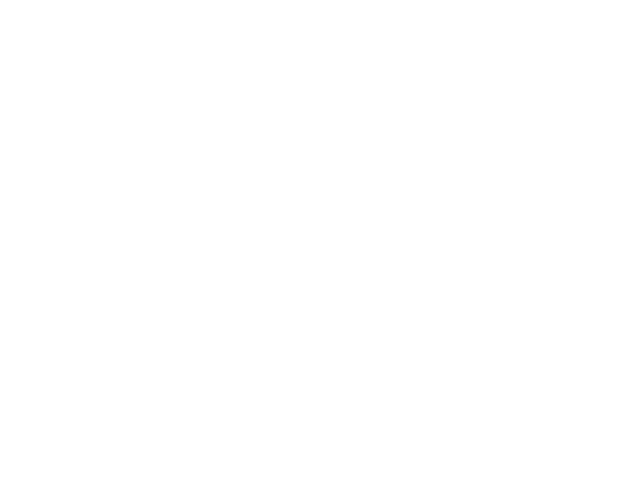

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1000, 1) 
n, bins, patches = ax.hist(messageArrivalRates["3GPP-006vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label=r'$\beta$ = 0.06', color="black")

ax.hist(messageArrivalRates["3GPP-012vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label=r'$\beta$ = 0.12', color="red")

ax.hist(messageArrivalRates["3GPP-02vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label=r'$\beta$ = 0.2', color="blue")

ax.hist(messageArrivalRates["3GPP-03vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label=r'$\beta$ = 0.3', color="green")


# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Inter packet arrival rate (ms)')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,400])
ax.set_xticks(np.arange(0,901, 100))
ax.set_yticks(np.arange(0,1.01, 0.1))

# plt.show()
plt.savefig("3GPP-packet-interarrival.eps")
plt.close()

<IPython.core.display.Javascript object>


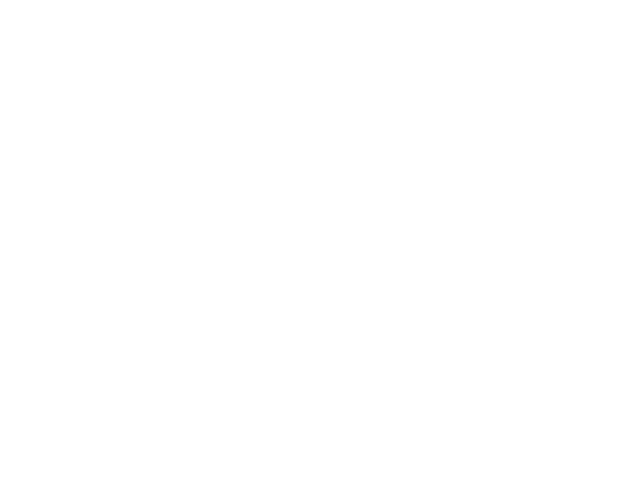

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1000, 1) 

# Overlay a reversed cumulative histogram.
n, bins, patches = ax.hist(messageArrivalRates["ETSI-006vpm"], bins=bins, density=True, histtype='step', cumulative=True,
        label=r'$\beta$ = 0.06', color="black")

# Overlay a reversed cumulative histogram.
ax.hist(messageArrivalRates["ETSI-012vpm"], bins=bins, density=True, histtype='step', cumulative=True,
        label=r'$\beta$ = 0.12', color="red")

# Overlay a reversed cumulative histogram.
ax.hist(messageArrivalRates["ETSI-02vpm"], bins=bins, density=True, histtype='step', cumulative=True,
        label=r'$\beta$ = 0.2', color="blue")

ax.hist(messageArrivalRates["ETSI-03vpm"], bins=bins, density=True, histtype='step',
                           cumulative=True, label=r'$\beta$ = 0.3', color="green")


# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Inter packet arrival rate (ms)')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,400])
ax.set_xticks(np.arange(0,901, 100))
ax.set_yticks(np.arange(0,1.01, 0.1))

# plt.show()
plt.savefig("ETSI-packet-interarrival.eps")
plt.close()

In [107]:
plt.savefig("3GPP-ETSI-packet-interarrival.eps")

In [16]:
plt.close()

In [15]:
etsi_pos_df = df_etsi[["NodeID", "Time", "posX", "posY"]]
etsi_drop = etsi_pos_df.dropna()
etsi_drop = etsi_drop.sort_values(by=["NodeID", "Time"])
etsi_drop["posXDiff"] = etsi_drop.diff()["posX"]
etsi_drop["posYDiff"] = etsi_drop.diff()["posY"]
# etsi_drop = etsi_drop[(etsi_drop["posXDiff"] > 0) | (etsi_drop["posYDiff"] > 0)]
etsi_drop["squareXDiff"] = etsi_drop["posXDiff"] ** 2
etsi_drop["squareYDiff"] = etsi_drop["posYDiff"] ** 2
etsi_drop["totalDist"] = (etsi_drop['squareXDiff'] + etsi_drop["squareYDiff"])**(1/2)
etsi_drop["speed"] = etsi_drop["totalDist"] * 1000
etsi_drop['match'] = etsi_drop["NodeID"].eq(etsi_drop["NodeID"].shift())
etsi_drop = etsi_drop[etsi_drop["match"] == True]
etsi_drop = etsi_drop[etsi_drop["speed"] < 19.44]

In [61]:
configs_etsi = {
    "ETSI-02vpm": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-02vpm-2021-01-24-11_27_16",
    "ETSI-03vpm": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-03vpm-2021-02-15-16_52_21",
    "ETSI-006vpm": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-006vpm-2021-01-24-11_27_16",
    "ETSI-012vpm": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-012vpm-2021-01-24-11_27_16"
}

In [65]:
speeds = {}
for config in configs_etsi:
    print("="*40)
    print(config)
    speed_run = []
    for run_num in range(1,6):
        print(run_num)
        for chunk in pd.read_csv("{}/run-{}.csv".format(configs[config], run_num), chunksize=10 ** 6):
            chunk = chunk[["NodeID", "Time", "posX", "posY"]]
            chunk = chunk.dropna()
            chunk = chunk.sort_values(by=["NodeID", "Time"])
            chunk["posXDiff"] = chunk.diff()["posX"]
            chunk["posYDiff"] = chunk.diff()["posY"]
            # etsi_drop = etsi_drop[(etsi_drop["posXDiff"] > 0) | (etsi_drop["posYDiff"] > 0)]
            chunk["squareXDiff"] = chunk["posXDiff"] ** 2
            chunk["squareYDiff"] = chunk["posYDiff"] ** 2
            chunk["totalDist"] = (chunk['squareXDiff'] + chunk["squareYDiff"])**(1/2)
            chunk["speed"] = chunk["totalDist"] * 1000
            chunk['match'] = chunk["NodeID"].eq(chunk["NodeID"].shift())
            chunk = chunk[chunk["match"] == True]
            if "006vpm" in config:
                chunk = chunk[chunk["speed"] < 38.89]
            elif "012vpm" in config:
                chunk = chunk[chunk["speed"] < 19.44]
            elif "02vpm" in config:
                chunk = chunk[chunk["speed"] < 11.94]
            elif "03vpm" in config:
                chunk = chunk[chunk["speed"] < 8]
            speed_run += chunk["speed"].to_list()
            
    print(sum(speed_run)/len(speed_run))
    speeds[config] = speed_run

ETSI-02vpm
1
2
3
4
5
10.38190490402002
ETSI-03vpm
1
2
3
4
5
6.482726272091491
ETSI-006vpm
1
2
3
4
5
32.80110537528299
ETSI-012vpm
1
2
3
4
5
16.00907102598539


<IPython.core.display.Javascript object>


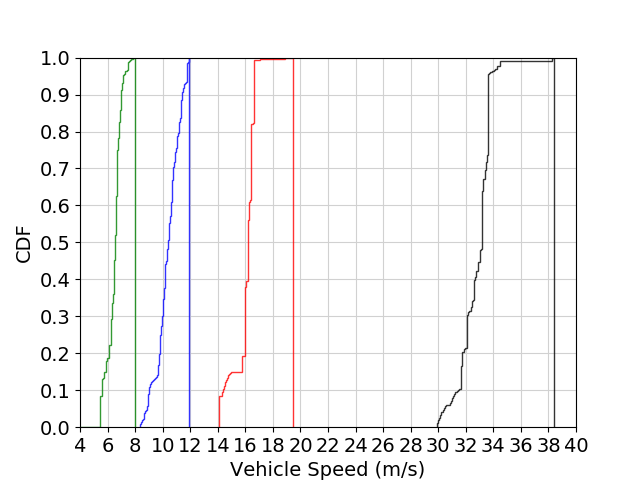

<ipython-input-43-c1c2899f6b76>:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(speeds["3GPP-006vpm"], bins=100, normed=True, cumulative=True,
<ipython-input-43-c1c2899f6b76>:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(speeds["3GPP-012vpm"], bins=100, normed=True, cumulative=True,
<ipython-input-43-c1c2899f6b76>:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(speeds["3GPP-02vpm"], bins=100, normed=True, cumulative=True,
<ipython-input-43-c1c2899f6b76>:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(speeds["3GPP-03vpm"], bins=100, normed=True, cumulative=True,


In [43]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 500, 1) 
n, bins, patches = ax.hist(speeds["3GPP-006vpm"], bins=100, normed=True, cumulative=True,
                           histtype='step', alpha=0.8, color='black')
ax.hist(speeds["3GPP-012vpm"], bins=100, normed=True, cumulative=True,
        histtype='step', alpha=0.8, color='red')
ax.hist(speeds["3GPP-02vpm"], bins=100, normed=True, cumulative=True,
        histtype='step', alpha=0.8, color='blue')
ax.hist(speeds["3GPP-03vpm"], bins=100, normed=True, cumulative=True,
        histtype='step', alpha=0.8, color='green')

# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.set_xlabel('Vehicle Speed (m/s)')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([4,40])
ax.set_xticks(np.arange(4,41, 2))
ax.set_yticks(np.arange(0,1.01, 0.1))

# plt.savefig("vehicle-speeds-012vpm.eps")
plt.show()

<IPython.core.display.Javascript object>


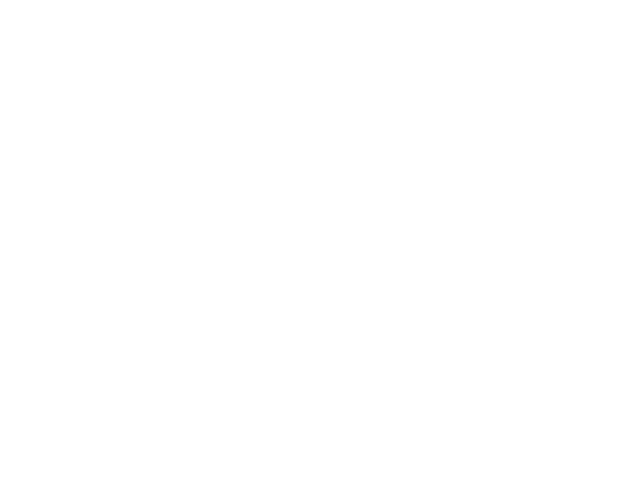

ValueError: x, y, and format string must not be None

In [45]:
fig, ax = plt.subplots()

bins = np.arange(0, 500, 1)

ax.step(speeds["ETSI-006vpm"].sort(),bins)

ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.set_xlabel('Vehicle Speed (m/s)')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([5,40])
ax.set_xticks(np.arange(5,40, 2))
ax.set_yticks(np.arange(0,1.01, 0.1))

# plt.savefig("vehicle-speeds-012vpm.eps")
plt.show()

In [66]:
speed_overwrite = speeds
for key in ["ETSI-006vpm", "ETSI-012vpm", "ETSI-02vpm", "ETSI-03vpm"]:
    speeds[key].append(41)

<IPython.core.display.Javascript object>


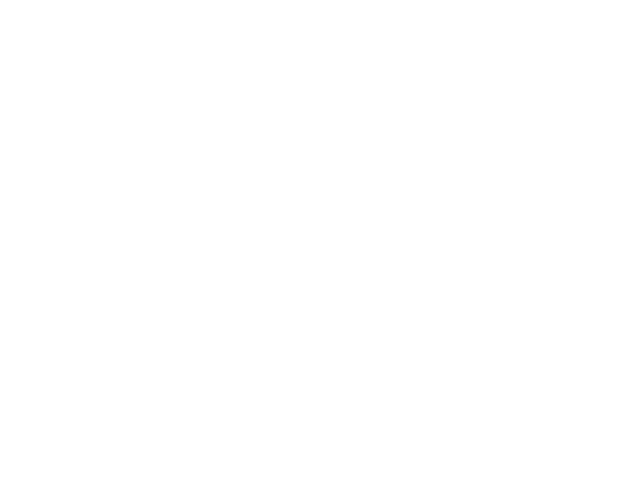

<ipython-input-77-f36f24e2e1ef>:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(speeds["ETSI-006vpm"], bins=100, normed=True, cumulative=True,
<ipython-input-77-f36f24e2e1ef>:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(speeds["ETSI-012vpm"], bins=100, normed=True, cumulative=True,
<ipython-input-77-f36f24e2e1ef>:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(speeds["ETSI-02vpm"], bins=100, normed=True, cumulative=True,
<ipython-input-77-f36f24e2e1ef>:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(speeds["ETSI-03vpm"], bins=100, normed=True, cumulative=True,
The PostScrip

In [77]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 500, 1) 
n, bins, patches = ax.hist(speeds["ETSI-006vpm"], bins=100, normed=True, cumulative=True,
                           histtype='step', alpha=0.8, color='black', label=r'$\beta$ = 0.06')
ax.hist(speeds["ETSI-012vpm"], bins=100, normed=True, cumulative=True,
        histtype='step', alpha=0.8, color='red', label=r'$\beta$ = 0.12')
ax.hist(speeds["ETSI-02vpm"], bins=100, normed=True, cumulative=True,
        histtype='step', alpha=0.8, color='blue', label=r'$\beta$ = 0.2')
ax.hist(speeds["ETSI-03vpm"], bins=100, normed=True, cumulative=True,
        histtype='step', alpha=0.8, color='green', label=r'$\beta$ = 0.3')

# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.legend(loc='lower center')
ax.set_axisbelow(True)
ax.set_xlabel('Vehicle Speed (m/s)')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([5,40])
ax.set_xticks(np.arange(5,40, 2))
ax.set_yticks(np.arange(0,1.01, 0.1))

plt.savefig("vehicle-speeds.eps")
plt.close()
# plt.show()